In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [16]:
# データフォルダのパス
data_folder = 'edit_data'

# データフォルダ内のすべてのCSVファイルを取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# 各CSVファイルを処理
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    temp_df = pd.read_csv(file_path)
    df = pd.concat([df, temp_df], ignore_index=True)
    
display(df)

,participant_id,time,scale,period,line_width,angle,font_size,stripe_color,text,input_text,accuracy,TorF
0,406,3755.0,50cm,6.0,3.0,135.0,16.0,128.0,2438,2438.0,1.0,T
1,406,3490.0,50cm,4.0,2.0,90.0,16.0,128.0,3492,3492.0,1.0,T
2,406,3376.0,50cm,6.0,3.0,45.0,16.0,128.0,2423,2423.0,1.0,T
3,406,3286.0,50cm,5.0,2.0,135.0,16.0,128.0,7306,7306.0,1.0,T
4,406,5019.0,50cm,8.0,3.0,135.0,16.0,128.0,5439,5439.0,1.0,T
...,...,...,...,...,...,...,...,...,...,...,...,...
331,408,5110.0,100cm,4.0,0.0,0.0,16.0,128.0,4298,4298.0,0.5,F
332,408,10983.0,100cm,5.0,1.0,135.0,16.0,128.0,6861,6861.0,0.5,F
333,408,3577.0,100cm,4.0,0.0,0.0,16.0,128.0,5639,5639.0,0.5,F
334,408,5404.0,100cm,7.0,3.0,135.0,16.0,128.0,1862,1652.0,0.0,F


In [17]:
sf_values = sorted(df['scale'].unique())
angle_values = sorted(df['angle'].unique())

# 集計: type, scale_factor, duty_cycle, line_period, line_angle ごとのサマリ
summary = df.groupby(['scale','line_width','period','angle']).agg(
    n=('accuracy','size'),
    mean_acc=('accuracy','mean'),
).reset_index()

display(summary)

,scale,line_width,period,angle,n,mean_acc
0,100cm,0.0,4.0,0.0,6,0.750
1,100cm,1.0,4.0,90.0,2,0.500
2,100cm,1.0,5.0,90.0,2,0.625
3,100cm,1.0,5.0,135.0,2,0.500
4,100cm,1.0,6.0,45.0,2,0.750
...,...,...,...,...,...,...
155,intended,3.0,8.0,45.0,2,0.750
156,intended,3.0,8.0,90.0,2,0.750
157,intended,3.0,8.0,135.0,2,0.750
158,intended,4.0,7.0,90.0,2,0.625


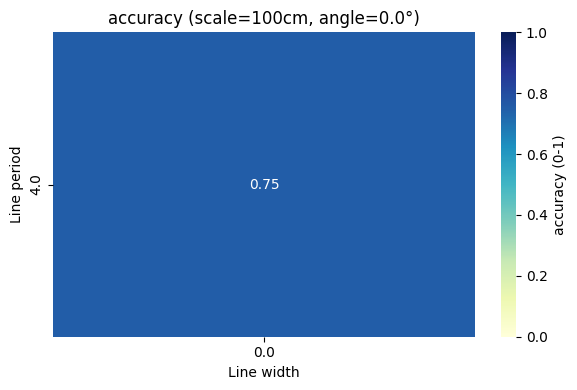

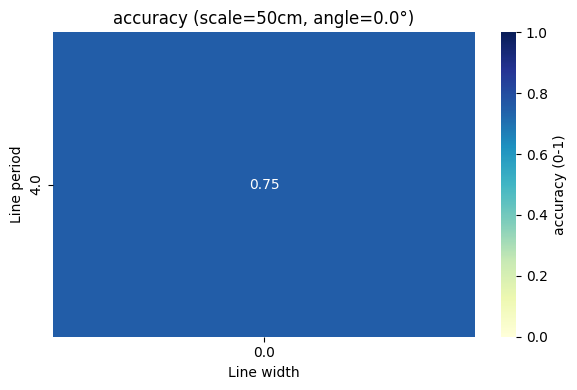

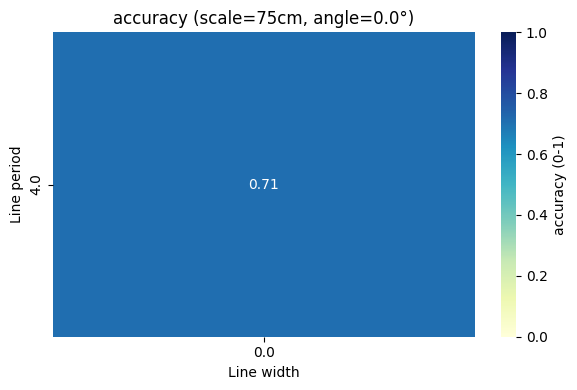

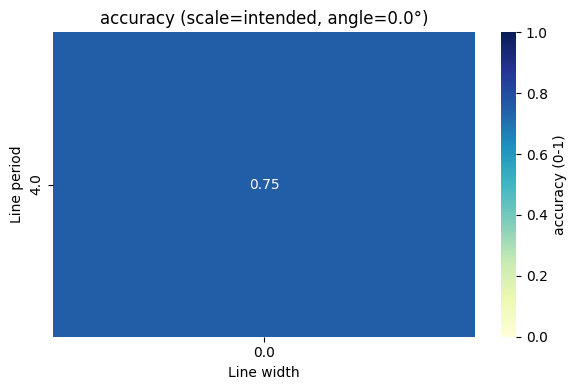

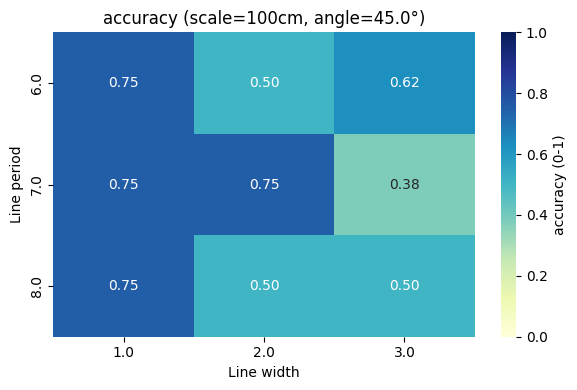

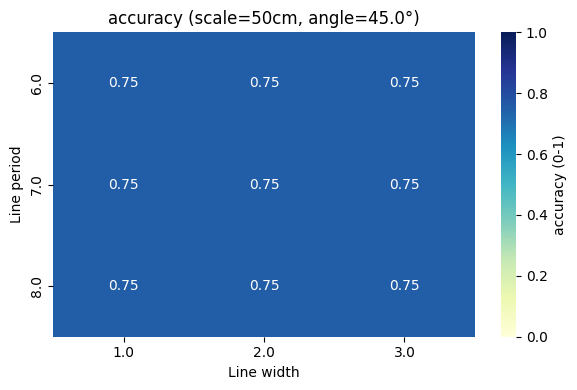

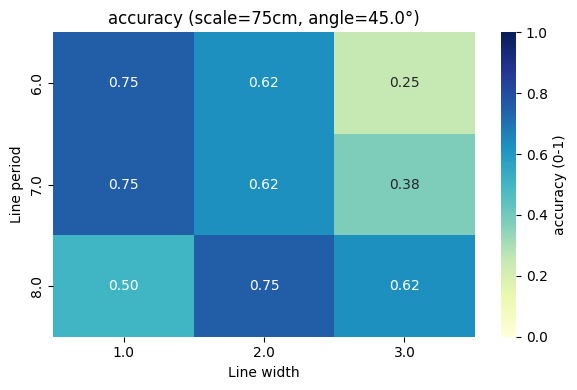

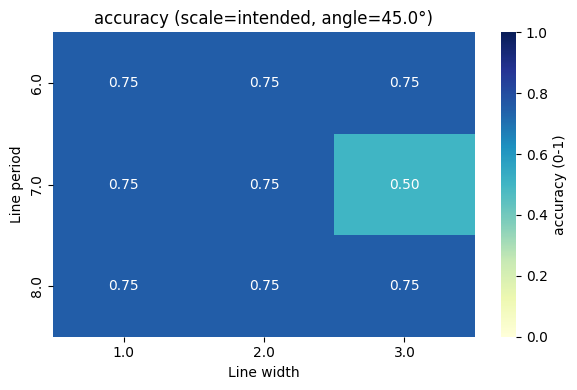

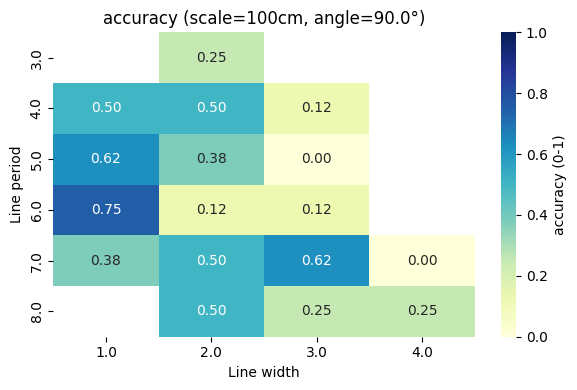

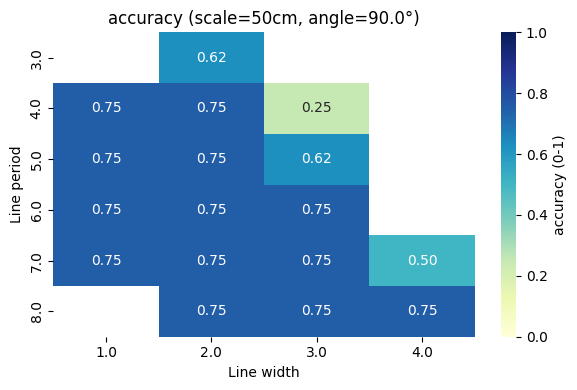

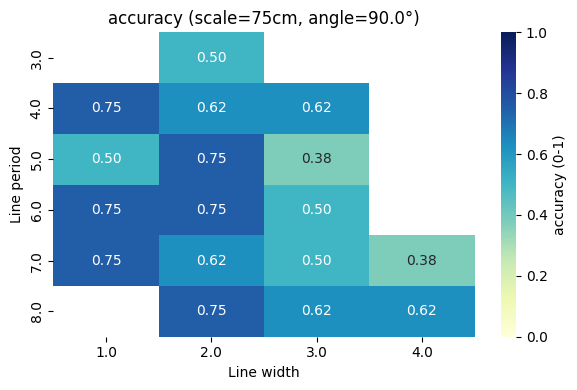

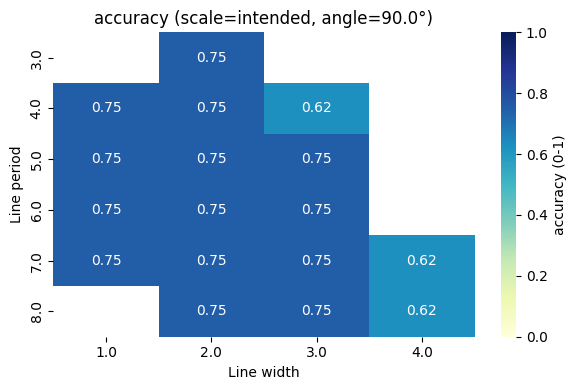

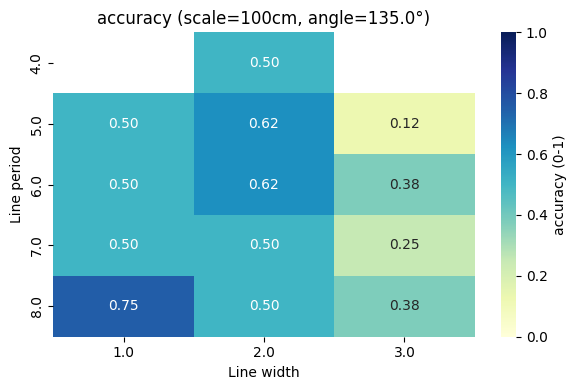

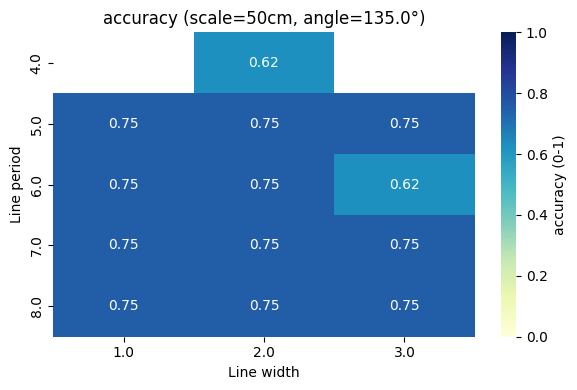

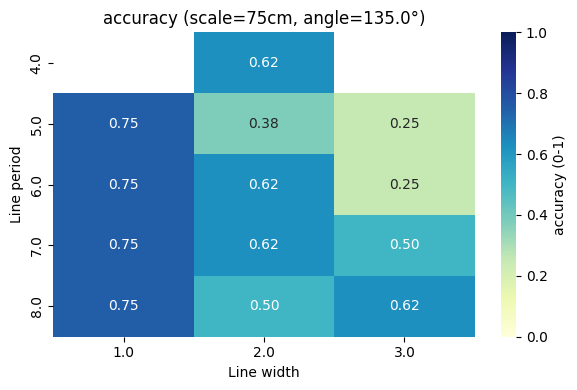

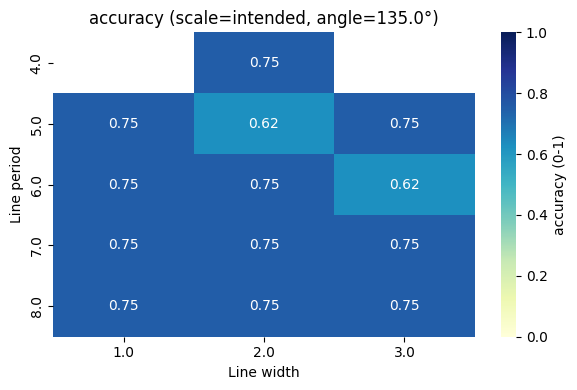

In [ ]:
# 角度ごとに line_period × line_width の平均 OCR 精度を計算してヒートマップを描画
for angle in sorted(df['angle'].unique()):
    sub = df[df['angle'] == angle]
    for scale in sorted(sub['scale'].unique()):
        sub_scale = sub[sub['scale'] == scale]
        # グルーピングして平均を取る
        pivot = sub_scale.groupby(['period', 'line_width'])['accuracy'].mean().unstack()
        if pivot.empty:
            continue
        plt.figure(figsize=(6, 4))
        sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1,
                    cbar_kws={'label': 'accuracy (0-1)'})
        plt.title(f'accuracy (scale={scale}, angle={angle}°)')
        plt.xlabel('Line width')
        plt.ylabel('Line period')
        plt.tight_layout()
        plt.show()